<a href="https://colab.research.google.com/github/gauravchak/risk_aware_feed_construction/blob/main/SPY_VIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yahoo_fin

In [84]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [4]:
from yahoo_fin import stock_info as si

# Get historical prices for SPY
spy_data = si.get_data('SPY')

# Get historical prices for VIX
vix_data = si.get_data('^VIX')

### Inspect data visually

In [5]:
spy_data

,open,high,low,close,adjclose,volume,ticker
1993-01-29,43.968750,43.968750,43.750000,43.937500,24.763737,1003200,SPY
1993-02-01,43.968750,44.250000,43.968750,44.250000,24.939867,480500,SPY
1993-02-02,44.218750,44.375000,44.125000,44.343750,24.992704,201300,SPY
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.256905,529400,SPY
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.362576,531500,SPY
...,...,...,...,...,...,...,...
2024-04-29,510.089996,510.750000,507.250000,510.059998,510.059998,46415400,SPY
2024-04-30,508.559998,509.559998,501.980011,501.980011,501.980011,77483600,SPY
2024-05-01,501.380005,508.190002,499.869995,500.350006,500.350006,80242800,SPY
2024-05-02,504.149994,505.890015,499.549988,505.029999,505.029999,62550200,SPY


In [6]:
vix_data

,open,high,low,close,adjclose,volume,ticker
1990-01-02,17.240000,17.240000,17.240000,17.240000,17.240000,0.0,^VIX
1990-01-03,18.190001,18.190001,18.190001,18.190001,18.190001,0.0,^VIX
1990-01-04,19.219999,19.219999,19.219999,19.219999,19.219999,0.0,^VIX
1990-01-05,20.110001,20.110001,20.110001,20.110001,20.110001,0.0,^VIX
1990-01-08,20.260000,20.260000,20.260000,20.260000,20.260000,0.0,^VIX
...,...,...,...,...,...,...,...
2024-04-29,15.370000,15.420000,14.630000,14.670000,14.670000,0.0,^VIX
2024-04-30,14.820000,15.900000,14.670000,15.650000,15.650000,0.0,^VIX
2024-05-01,15.750000,16.219999,14.350000,15.390000,15.390000,0.0,^VIX
2024-05-02,15.140000,16.090000,14.600000,14.680000,14.680000,0.0,^VIX


### Merge data
See that last row matches expectations

In [12]:
# Merge the dataframes on the common dates
merged_data = pd.merge(spy_data, vix_data, left_index=True, right_index=True, how='inner')

In [15]:
merged_data.tail(1)

,open_x,high_x,low_x,close_x,adjclose_x,volume_x,ticker_x,open_y,high_y,low_y,close_y,adjclose_y,volume_y,ticker_y
2024-05-03,511.160004,512.549988,508.559998,511.290009,511.290009,72756709,SPY,14.51,14.58,13.48,13.49,13.49,0.0,^VIX


In [16]:
spy_data.tail(1)

,open,high,low,close,adjclose,volume,ticker
2024-05-03,511.160004,512.549988,508.559998,511.290009,511.290009,72756709,SPY


In [17]:
vix_data.tail(1)

,open,high,low,close,adjclose,volume,ticker
2024-05-03,14.51,14.58,13.48,13.49,13.49,0.0,^VIX


### Inverse Risk allocation

1. Compute the mean value of VIX in the period
2. Find the net portfolio scale that one would have every day based on the formula Mean(VIX) / VIX that day.
3. Compute returns of SPY
4. The returns of inverse risk allocation on a day = returns of SPY * the scale determined by inverse risk . To make this slightly transaction efficient we use a rolling 3 day average.

In [19]:
VIX_mean = merged_data['close_y'].mean()

In [22]:
merged_data['inv_risk_mult'] = VIX_mean / merged_data['close_y']

In [23]:
merged_data['SPY_returns'] = merged_data['close_x'].pct_change()

In [79]:
# Going forward we only need the closing price of SPY and the inverse risk allocation multiplier
relevant_data = merged_data[['SPY_returns', 'inv_risk_mult']]

# Create the 'smooth_inv_risk_mult' column by computing a rolling 3 day average
# of inv_risk_mult. This makes the portfolio slightly easier to transact.
relevant_data['smooth_inv_risk_mult'] = relevant_data['inv_risk_mult'].rolling(window=3).mean()

In [80]:
# ignore-warnings
avg_scale = relevant_data["smooth_inv_risk_mult"].mean()
relevant_data['smooth_inv_risk_mult'] = (relevant_data['smooth_inv_risk_mult'].fillna(avg_scale) / avg_scale)
print(f'Average scale of risk aware portfolio = {avg_scale}')

Average scale of risk aware portfolio = 1.1350195273112615


In [81]:
relevant_data['risk_aware_portfolio_return'] = relevant_data['SPY_returns'] * relevant_data['smooth_inv_risk_mult']

relevant_data.drop(columns=['inv_risk_mult', 'smooth_inv_risk_mult'], inplace=True)

## Visualize how risk aware portfolios increase net return and reduce drawdowns (risk)

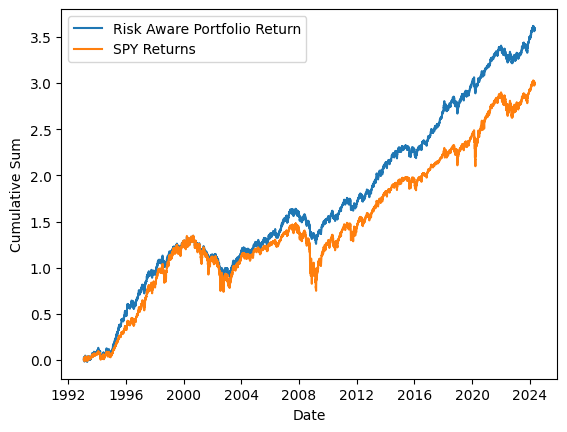

In [82]:
import matplotlib.pyplot as plt

# Compute the cumulative sum of the 'risk_aware_portfolio_return' and 'SPY_returns' columns
cumulative_risk_aware_portfolio_return = relevant_data['risk_aware_portfolio_return'].cumsum()
cumulative_SPY_returns = (relevant_data['SPY_returns']).cumsum()

# Plot the cumulative sums
plt.plot(relevant_data.index, cumulative_risk_aware_portfolio_return, label='Risk Aware Portfolio Return')
plt.plot(relevant_data.index, cumulative_SPY_returns, label='SPY Returns')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Cumulative Sum')
plt.legend()

# Show the plot
plt.show()

In [88]:
print(f'The final risk aware portfolio value is {np.exp(cumulative_risk_aware_portfolio_return[-1] - cumulative_SPY_returns[-1]):.2f} times more than the original portfolio.')

The final risk aware portfolio value is 1.81 times more than the original portfolio.
